# Notebook magique with AutoML

TO DO:
- remove outliers: implement new fucntion + get right percentage
- test different numbers of topics and clusters 

See 
https://github.com/parklize/cikm2020-analyticup?fbclid=IwAR0Ti_pF7HrIO5ELFlvA1b2FEL_D68xlu_XdXeFxyARzBfY5U7a040klHTM

In [43]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from verstack.stratified_continuous_split import scsplit  # pip install verstack


# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")


Split data

In [44]:
# split data
#X_train, X_test, y_train, y_test = scsplit(
#    train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
# X_train = X_train.drop(['retweets_count'], axis=1)
# X_test = X_test.drop(['retweets_count'], axis=1)


# split data using sklearn
X = train_data.drop('retweets_count',axis=1)
y = train_data['retweets_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Outliers

In [45]:
# remove outliers with quartile
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df

In [66]:
# remove outliers with given percentage p
def remove_outliers_percentage(df, col, p):
    q = df[col].quantile(1 - p / 100)
    df = df[df[col] < q]
    return df

In [67]:
# rs_df = remove_outliers_percentage(rs_df, 'followers_count', 2)


# 2% of outliers are removed for 3 variables. In total 5 to 6% of  data is removed

q = raw_data_mod_2["UserFollowersCount"].quantile(0.98)
data_1 = raw_data_mod_2[raw_data_mod_2["UserFollowersCount"]<q]


q2 = data_1["UserFriendsCount"].quantile(0.98)
data_2 = data_1[data_1["UserFriendsCount"]<q2]


q3 = data_2["UserTweetCount"].quantile(0.98)
data_3 = data_2[data_2["UserTweetCount"]<q3]
data_3.info()

In [46]:
def feature_engineering(in_df):
    rs_df = in_df

    # mentions is always empty -> DROP Mention
    rs_df = rs_df.drop(['mentions'], axis=1)

    # add a column to data which counts url
    rs_df['url_count'] = rs_df['urls'].str.count('http')
    rs_df = rs_df.drop(['urls'], axis=1)
    # add a column to data which gives length of hashtags
    # TO DO
    # add columns to data which makes ratios
    rs_df['followers_friends'] = rs_df['followers_count'] / \
        (rs_df['friends_count'].apply(lambda x: x+1))
    rs_df['favorites_followers'] = rs_df['favorites_count'] / \
        (rs_df['followers_count'].apply(lambda x: x+1))
    rs_df['favorites_friends'] = rs_df['favorites_count'] / \
        (rs_df['friends_count'].apply(lambda x: x+1))
    return rs_df

In [47]:
from datetime import datetime


def time_engineering(in_df):
    rs_df = in_df
    rs_df["hour"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).hour))
    rs_df["day"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    rs_df["week_in_month"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).day)//7)
        
    rs_df.drop(['timestamp'], axis=1)

    return rs_df

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords


def extract_topic(df):
    rs_df = df
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    #join text and hashtags
    rs_df['total_text'] = rs_df['text'] + ' ' + rs_df['hashtags']
    vectorizer = TfidfVectorizer(min_df=1, max_features=None, stop_words=stopwords.words('french'))
    vector = vectorizer.fit_transform(df['text'])
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(vector)
    topic=svd.transform(vector)
    rs_df['topic_1'] = topic[:,0]
    rs_df['topic_2'] = topic[:,1]
    rs_df['topic_3'] = topic[:,2]
    rs_df['topic_4'] = topic[:,3]
    rs_df['topic_5'] = topic[:,4]
    return rs_df

In [49]:
from textblob import TextBlob  # pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer


def text_engineering(in_df):
    rs_df = in_df
    # add columns related to sentiment analysis
    rs_df['polarity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    rs_df['subjectivity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])
    # drop the text column
    rs_df = rs_df.drop(['text'], axis=1)

    return rs_df

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


def hashtags_engineering(in_df):
    rs_df = in_df
    # make a string of the list
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))

    # has hashtags or not
    rs_df['has_hashtags'] = rs_df['hashtags'].apply(
        lambda x: 0 if x == '' else 1)

    # drop the hashtags column
    rs_df = rs_df.drop(['hashtags'], axis=1)
    return rs_df

In [51]:
#import kmeans
from sklearn.cluster import KMeans


def extract_cluster(df,columns):
    rs_df = df
    rs_df['cluster'] = KMeans(n_clusters=1000, random_state=0).fit_predict(rs_df[columns].values.reshape(-1, 1))
    return rs_df

## Scaler

In [52]:
def logtransformdrop(dataframe, cols):
    for col in cols:
        dataframe[col] = dataframe[col].apply(lambda x: np.log10(int(x)+1))
    return dataframe

## Data processing

In [53]:
col = ['TweetID', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'favorites_followers', 'favorites_friends', 'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'has_hashtags', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5']#add cluster


In [55]:
new_X_train = feature_engineering(X_train)
new_X_train = time_engineering(new_X_train)
new_X_train = extract_topic(new_X_train)
new_X_train = text_engineering(new_X_train)
new_X_train = hashtags_engineering(new_X_train)
#new_X_train = extract_cluster(new_X_train,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_train = new_X_train.reindex(columns=col)
new_X_train.head()


,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,favorites_followers,favorites_friends,...,day,week_in_month,polarity,subjectivity,has_hashtags,topic_1,topic_2,topic_3,topic_4,topic_5
103289,909349,595,478,0,108881,0,0,1.242171,0.000000,0.000000,...,4,1,0.00,0.00,0,0.146713,-0.111524,-0.098801,0.002862,-0.053642
86587,742857,290,980,0,531,0,0,0.295617,0.000000,0.000000,...,6,1,0.00,0.00,0,0.035531,0.004630,0.030695,-0.041202,0.166321
15776,1418828,425,1755,0,5082,0,0,0.242027,0.000000,0.000000,...,5,2,0.00,0.00,0,0.117640,0.017269,0.178240,-0.022425,-0.060510
19725,1341951,29,52,1,2904,0,1,0.547170,0.033333,0.018868,...,5,2,-0.45,0.40,0,0.049772,-0.001164,-0.009607,0.026153,0.024819
219175,899183,14,222,0,572,0,0,0.062780,0.000000,0.000000,...,4,1,-0.10,0.15,0,0.020517,-0.001925,0.000758,0.006547,0.011615


## Flaml

In [58]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'mae',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
    # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'regression',  # task type
    # ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
    'estimator_list': ['rf', 'extra_tree'],
    "seed": 7654321,    # random seed
}

automl.fit(new_X_train.drop(['TweetID'], axis=1), y_train, **settings)
# Print the best model
print(automl.model.estimator)


[flaml.automl: 11-23 01:56:00] {2599} INFO - task = regression
[flaml.automl: 11-23 01:56:00] {2601} INFO - Data split method: uniform
[flaml.automl: 11-23 01:56:00] {2604} INFO - Evaluation method: holdout
[flaml.automl: 11-23 01:56:00] {2726} INFO - Minimizing error metric: mae
[flaml.automl: 11-23 01:56:00] {2870} INFO - List of ML learners in AutoML Run: ['rf', 'extra_tree']
[flaml.automl: 11-23 01:56:00] {3166} INFO - iteration 0, current learner rf
[flaml.automl: 11-23 01:56:00] {3296} INFO - Estimated sufficient time budget=18683s. Estimated necessary time budget=19s.
[flaml.automl: 11-23 01:56:00] {3343} INFO -  at 0.9s,	estimator rf's best error=17.4274,	best estimator rf's best error=17.4274
[flaml.automl: 11-23 01:56:00] {3166} INFO - iteration 1, current learner extra_tree
[flaml.automl: 11-23 01:56:00] {3343} INFO -  at 0.9s,	estimator extra_tree's best error=20.5888,	best estimator rf's best error=17.4274
[flaml.automl: 11-23 01:56:00] {3166} INFO - iteration 2, current l

[flaml.automl: 11-23 01:56:05] {3343} INFO -  at 5.9s,	estimator extra_tree's best error=10.0439,	best estimator rf's best error=9.2256
[flaml.automl: 11-23 01:56:05] {3166} INFO - iteration 37, current learner rf
[flaml.automl: 11-23 01:56:07] {3343} INFO -  at 7.4s,	estimator rf's best error=8.9280,	best estimator rf's best error=8.9280
[flaml.automl: 11-23 01:56:07] {3166} INFO - iteration 38, current learner extra_tree
[flaml.automl: 11-23 01:56:07] {3343} INFO -  at 7.6s,	estimator extra_tree's best error=10.0439,	best estimator rf's best error=8.9280
[flaml.automl: 11-23 01:56:07] {3166} INFO - iteration 39, current learner extra_tree
[flaml.automl: 11-23 01:56:07] {3343} INFO -  at 7.6s,	estimator extra_tree's best error=9.7666,	best estimator rf's best error=8.9280
[flaml.automl: 11-23 01:56:07] {3166} INFO - iteration 40, current learner rf
[flaml.automl: 11-23 01:56:08] {3343} INFO -  at 8.4s,	estimator rf's best error=8.7746,	best estimator rf's best error=8.7746
[flaml.auto

[flaml.automl: 11-23 01:57:24] {3166} INFO - iteration 75, current learner extra_tree
[flaml.automl: 11-23 01:57:26] {3343} INFO -  at 86.9s,	estimator extra_tree's best error=8.2590,	best estimator rf's best error=8.2581
[flaml.automl: 11-23 01:57:26] {3166} INFO - iteration 76, current learner extra_tree
[flaml.automl: 11-23 01:57:28] {3343} INFO -  at 88.9s,	estimator extra_tree's best error=8.2412,	best estimator extra_tree's best error=8.2412
[flaml.automl: 11-23 01:57:28] {3166} INFO - iteration 77, current learner extra_tree
[flaml.automl: 11-23 01:57:30] {3343} INFO -  at 90.5s,	estimator extra_tree's best error=8.2412,	best estimator extra_tree's best error=8.2412
[flaml.automl: 11-23 01:57:30] {3166} INFO - iteration 78, current learner extra_tree
[flaml.automl: 11-23 01:57:32] {3343} INFO -  at 92.9s,	estimator extra_tree's best error=8.2070,	best estimator extra_tree's best error=8.2070
[flaml.automl: 11-23 01:57:32] {3166} INFO - iteration 79, current learner extra_tree
[f

[flaml.automl: 11-23 01:59:02] {3166} INFO - iteration 111, current learner extra_tree
[flaml.automl: 11-23 01:59:05] {3343} INFO -  at 185.6s,	estimator extra_tree's best error=8.0509,	best estimator extra_tree's best error=8.0509
[flaml.automl: 11-23 01:59:05] {3166} INFO - iteration 112, current learner extra_tree
[flaml.automl: 11-23 01:59:06] {3343} INFO -  at 186.9s,	estimator extra_tree's best error=8.0357,	best estimator extra_tree's best error=8.0357
[flaml.automl: 11-23 01:59:06] {3166} INFO - iteration 113, current learner extra_tree
[flaml.automl: 11-23 01:59:07] {3343} INFO -  at 187.9s,	estimator extra_tree's best error=8.0357,	best estimator extra_tree's best error=8.0357
[flaml.automl: 11-23 01:59:07] {3166} INFO - iteration 114, current learner extra_tree
[flaml.automl: 11-23 01:59:09] {3343} INFO -  at 189.4s,	estimator extra_tree's best error=8.0357,	best estimator extra_tree's best error=8.0357
[flaml.automl: 11-23 01:59:09] {3166} INFO - iteration 115, current lear

[flaml.automl: 11-23 02:00:01] {3343} INFO -  at 241.2s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:00:01] {3166} INFO - iteration 147, current learner extra_tree
[flaml.automl: 11-23 02:00:04] {3343} INFO -  at 244.2s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:00:04] {3166} INFO - iteration 148, current learner extra_tree
[flaml.automl: 11-23 02:00:05] {3343} INFO -  at 245.5s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:00:05] {3166} INFO - iteration 149, current learner extra_tree
[flaml.automl: 11-23 02:00:08] {3343} INFO -  at 248.5s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:00:08] {3166} INFO - iteration 150, current learner extra_tree
[flaml.automl: 11-23 02:00:11] {3343} INFO -  at 251.8s,	estimator extra

[flaml.automl: 11-23 02:01:14] {3166} INFO - iteration 182, current learner extra_tree
[flaml.automl: 11-23 02:01:16] {3343} INFO -  at 316.6s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:01:16] {3166} INFO - iteration 183, current learner extra_tree
[flaml.automl: 11-23 02:01:18] {3343} INFO -  at 318.2s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:01:18] {3166} INFO - iteration 184, current learner extra_tree
[flaml.automl: 11-23 02:01:20] {3343} INFO -  at 320.1s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:01:20] {3166} INFO - iteration 185, current learner extra_tree
[flaml.automl: 11-23 02:01:21] {3343} INFO -  at 321.9s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:01:21] {3166} INFO - iteration 186, current lear

[flaml.automl: 11-23 02:02:40] {3166} INFO - iteration 218, current learner rf
[flaml.automl: 11-23 02:02:45] {3343} INFO -  at 405.4s,	estimator rf's best error=8.2581,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:02:45] {3166} INFO - iteration 219, current learner extra_tree
[flaml.automl: 11-23 02:02:46] {3343} INFO -  at 407.0s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:02:46] {3166} INFO - iteration 220, current learner extra_tree
[flaml.automl: 11-23 02:02:48] {3343} INFO -  at 408.8s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:02:48] {3166} INFO - iteration 221, current learner rf
[flaml.automl: 11-23 02:03:00] {3343} INFO -  at 420.9s,	estimator rf's best error=8.2581,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:03:00] {3166} INFO - iteration 222, current learner extra_tree
[flaml.automl: 11

[flaml.automl: 11-23 02:04:24] {3166} INFO - iteration 254, current learner extra_tree
[flaml.automl: 11-23 02:04:26] {3343} INFO -  at 506.1s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:04:26] {3166} INFO - iteration 255, current learner extra_tree
[flaml.automl: 11-23 02:04:28] {3343} INFO -  at 508.4s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:04:28] {3166} INFO - iteration 256, current learner extra_tree
[flaml.automl: 11-23 02:04:30] {3343} INFO -  at 510.3s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:04:30] {3166} INFO - iteration 257, current learner extra_tree
[flaml.automl: 11-23 02:04:32] {3343} INFO -  at 513.0s,	estimator extra_tree's best error=7.9846,	best estimator extra_tree's best error=7.9846
[flaml.automl: 11-23 02:04:32] {3166} INFO - iteration 258, current lear

[flaml.automl: 11-23 02:05:49] {3343} INFO -  at 589.6s,	estimator extra_tree's best error=7.9592,	best estimator extra_tree's best error=7.9592
[flaml.automl: 11-23 02:05:49] {3166} INFO - iteration 290, current learner extra_tree
[flaml.automl: 11-23 02:05:51] {3343} INFO -  at 591.8s,	estimator extra_tree's best error=7.9592,	best estimator extra_tree's best error=7.9592
[flaml.automl: 11-23 02:05:51] {3166} INFO - iteration 291, current learner extra_tree
[flaml.automl: 11-23 02:05:55] {3343} INFO -  at 595.5s,	estimator extra_tree's best error=7.9592,	best estimator extra_tree's best error=7.9592
[flaml.automl: 11-23 02:05:55] {3166} INFO - iteration 292, current learner extra_tree
[flaml.automl: 11-23 02:05:57] {3343} INFO -  at 597.4s,	estimator extra_tree's best error=7.9592,	best estimator extra_tree's best error=7.9592
[flaml.automl: 11-23 02:06:00] {3602} INFO - retrain extra_tree for 3.4s
[flaml.automl: 11-23 02:06:00] {3609} INFO - retrained model: ExtraTreesRegressor(max_

ExtraTreesRegressor(max_features=0.6850807034407049, max_leaf_nodes=32767,
                    n_estimators=19, n_jobs=-1)


In [59]:
print(automl.model.estimator)


ExtraTreesRegressor(max_features=0.6850807034407049, max_leaf_nodes=32767,
                    n_estimators=19, n_jobs=-1)



AutoML.fit(self, X_train, y_train, dataframe, label, metric, task, n_jobs, log_file_name, estimator_list, time_budget, max_iter, sample, ensemble, eval_method, log_type, model_history, split_ratio, n_splits, log_training_metric, mem_thres, pred_time_limit, train_time_limit, X_val, y_val, sample_weight_val, groups_val, groups, verbose, retrain_full, split_type, learner_selector, hpo_method, starting_points, seed, n_concurrent_trials, keep_search_state, preserve_checkpoint, early_stop, append_log, auto_augment, min_sample_size, use_ray, metric_constraints, custom_hp, cv_score_agg_func, skip_transform, fit_kwargs_by_estimator, **fit_kwargs)


xgboost, rf, lgbm, extra_tree

# Submission

In [60]:
# test on X_test
new_X_test = feature_engineering(X_test)
new_X_test = time_engineering(new_X_test)
new_X_test = text_engineering(new_X_test)
new_X_test = hashtags_engineering(new_X_test)
#new_X_train=logtransformdrop(X_train,['followers.count','friends_count','favorites_count','followers_count'])
new_X_test = new_X_test.reindex(columns=col)
new_X_test.head()


,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,favorites_followers,favorites_friends,...,day,week_in_month,polarity,subjectivity,has_hashtags,topic_1,topic_2,topic_3,topic_4,topic_5
307625,433464,125,212,0,10166,0,1,0.586854,0.000000,0.000000,...,3,2,0.200,0.0000,0,NaN,NaN,NaN,NaN,NaN
52950,1037660,28,200,0,1654,0,1,0.139303,0.000000,0.000000,...,0,2,0.245,0.2875,0,NaN,NaN,NaN,NaN,NaN
289882,1075200,2664,4973,0,387033,0,0,0.535585,0.000000,0.000000,...,0,2,-0.320,0.4000,0,NaN,NaN,NaN,NaN,NaN
17637,1219542,610,37,0,144562,0,0,16.052632,0.000000,0.000000,...,4,2,0.050,0.3000,0,NaN,NaN,NaN,NaN,NaN
339255,451776,12817,1751,1,45052,0,1,7.315639,0.000078,0.000571,...,3,2,0.000,0.0000,0,NaN,NaN,NaN,NaN,NaN


In [61]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.052162320113681875,
             max_delta_step=0, max_depth=8, min_child_weight=0.1063699762688744,
             monotone_constraints='()', n_estimators=210,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.0009765625, reg_lambda=0.12350542443726754,
             scale_pos_weight=1, subsample=0.9086898548301782,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=0)
model.fit(new_X_train.drop(['TweetID'], axis=1), y_train)
y_pred = model.predict(new_X_test.drop(
    ['TweetID'], axis=1))
print(mean_absolute_error(y_test, y_pred))


12.865245677629904


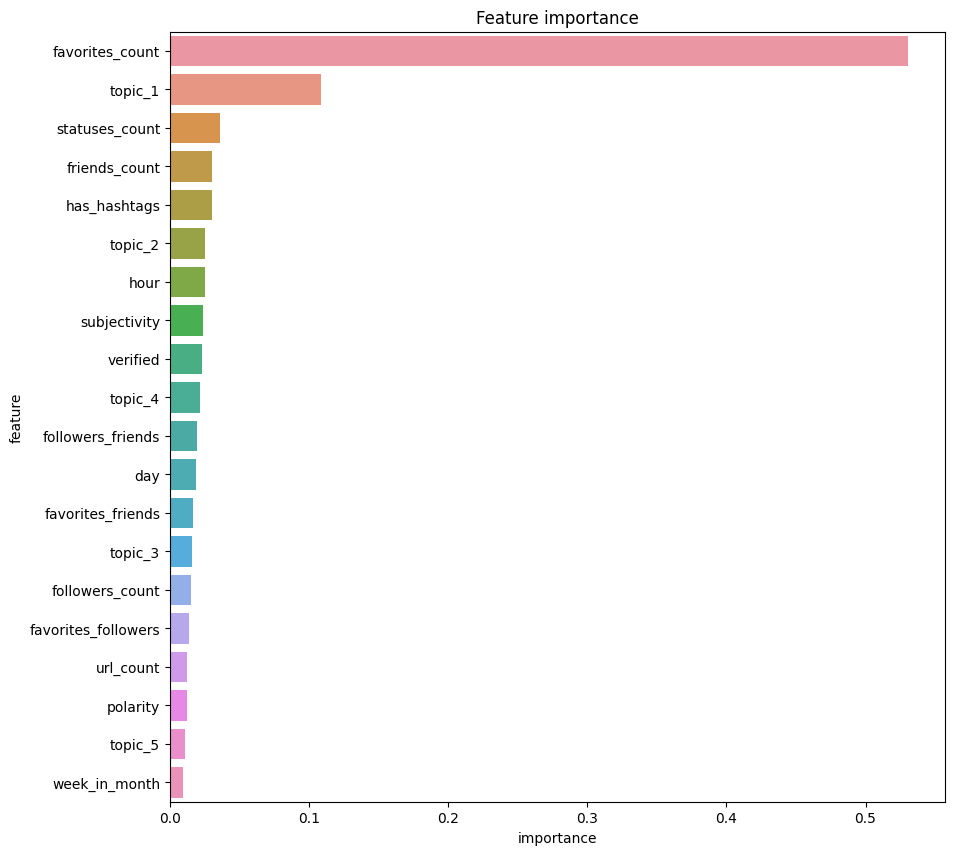

<AxesSubplot: >

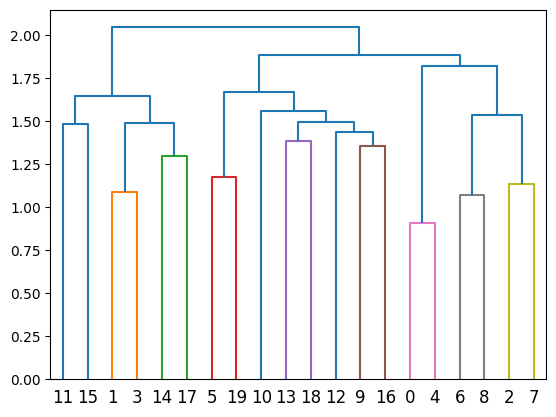

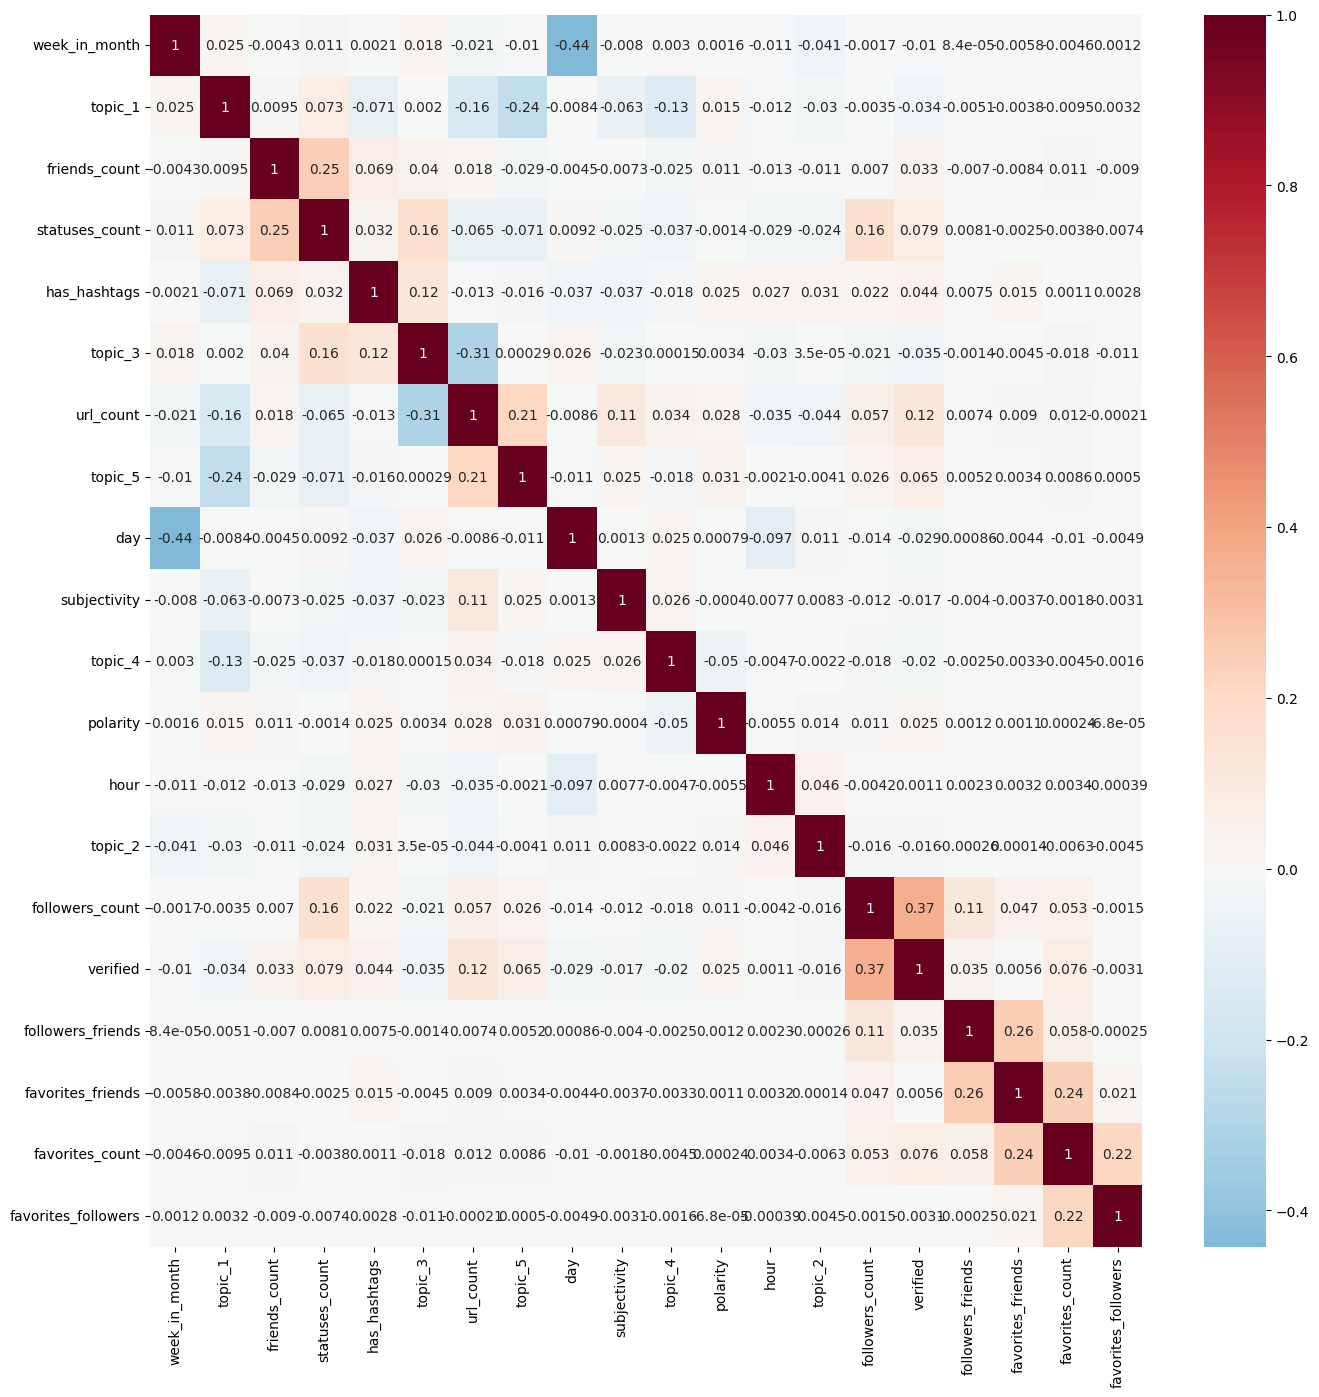

In [62]:
import seaborn as sbn
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_X_train.drop(
    ['TweetID'], axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(
    by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_X_train.drop(['TweetID'], axis=1).corr()), no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_X_train.drop(
    ['TweetID'], axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sbn.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)


In [63]:
# plot model mse with number of top features
# TO DO
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest


### Models to consider
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]))

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [65]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
 


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))



results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py", line 809, in fit
    return self.partial_fit(X, y, sample_weight)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py", line 844, in partial_fit
    X = self._validate_data(
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 577, in _validate_data
    X = check_array(X, input_name="X", **check_params)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'justement chercher problème perso questions sécurité cherche cacher but faire comm prix carburant vois station service prévenue zemmour équipe arrive'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py", line 809, in fit
    return self.partial_fit(X, y, sample_weight)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py", line 844, in partial_fit
    X = self._validate_data(
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 577, in _validate_data
    X = check_array(X, input_name="X", **check_params)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "C:\Users\33638\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'voter macron nne'
